# California Fire Data Ingestion

**Dataset**: CAL FIRE Historical Fire Perimeters (fire24_1.gdb)  
**Date Range**: 1878 - 2025 (focusing on 2000-2025 for modeling)  
**Source**: [CAL FIRE FRAP](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters)

**Objective**: 
- Load and validate historical California fire data
- Verify data quality and completeness
- Understand dataset structure and features
- Document January 2025 fires in California
- Prepare for comprehensive EDA in Phase 2


## Why Historical Fire Data Matters for Prediction

Understanding past fire patterns is fundamental to predicting future fire risk. Historical fire data provides:

### **1. Spatial Patterns** 🗺️
- **Fire-prone zones**: Some areas burn repeatedly due to geography, vegetation, and climate
- **Fire frequency**: How often does each region experience fires?
- **Fire clustering**: Do fires tend to occur near previous burns?
- **Geographic risk factors**: Identify consistently high-risk counties and landscapes

### **2. Temporal Patterns** 📅
- **Seasonality**: California fire season traditionally May-October, but January 2025 fires show patterns changing
- **Multi-year trends**: Are fires increasing in frequency and size?
- **Climate change signals**: Longer fire seasons, earlier starts, later ends
- **Fire return intervals**: How long between fires in the same location?

### **3. Fire Behavior Insights** 🔥
- **Fire size distribution**: Most fires small, but large fires cause most damage
- **Fire duration**: Days from ignition to containment
- **Rapid vs. slow-growing fires**: What conditions lead to explosive growth?

### **4. Ignition Source Intelligence** ⚡
- **Human vs. natural causes**: Power lines, equipment, campfires vs. lightning
- **Cause-specific patterns**: When and where do different ignition sources occur?
- **Risk mitigation**: Target prevention efforts based on common causes

### **5. Model Training Foundation** 🤖
- **Labeled examples**: Historical fires = positive class, non-fire events = negative class
- **Feature importance**: Which conditions consistently preceded fires?
- **Validation dataset**: Test predictions against known fire outcomes
- **Spatial-temporal learning**: Model learns "when + where = fire risk"

### **Key Insight for Modeling:**
By analyzing 147 years of fire history (1878-2025), we can identify the environmental signatures that precede fires and use those patterns to predict future risk before ignition occurs.


In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")


/Users/ccfi-capp/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✅ Libraries imported successfully!


### Dataset Columns Explained

The CAL FIRE fire perimeters dataset contains rich attributes for each fire:

#### Key Columns:

| Column | Description | Usage in Fire Prediction |
|--------|-------------|--------------------------|
| **FIRE_NAME** | Name of the fire (UPPER CASE) | Identification |
| **YEAR_** | Year fire started | Temporal trends |
| **ALARM_DATE** | Fire discovery date (DD/MM/YYYY) | When fire began |
| **CONT_DATE** | Containment date | Fire duration |
| **GIS_ACRES** | Fire size in acres | Fire severity/impact |
| **CAUSE** | Ignition source (coded) | Human vs. natural, ignition patterns |
| **UNIT_ID** | Fire unit/agency code | Geographic location |
| **STATE** | State (CA, NV, OR, AZ) | Geographic filter |
| **AGENCY** | Responsible agency | Management classification |
| **geometry** | Fire perimeter polygon | Spatial analysis |

#### CAUSE Codes (Fire Ignition Sources):
According to the [CAL FIRE Data Dictionary](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters), causes include:
- **Lightning** (natural ignition)
- **Equipment Use** (machinery, power tools)
- **Electrical Power** (power lines - major cause in CA!)
- **Arson** (deliberate ignition)
- **Debris Burning** (controlled burns that escape)
- **Campfire** (recreational fires)
- **Railroad** (train sparks)
- **Smoking** (cigarettes)
- **Miscellaneous** (other sources)
- **Unknown** (cause not determined)

#### Data Source:
- **Agency**: CAL FIRE Fire and Resource Assessment Program (FRAP)
- **URL**: [CAL FIRE Fire Perimeters](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters)
- **Data Dictionary**: [PDF Documentation](https://www.fire.ca.gov/media/fire-perimeters-data-dictionary.pdf)
- **Update Frequency**: Annually (latest: April 2025)
- **Coverage**: Federal, state, and local fire agencies across California


## 1. Load Fire Perimeter Data


In [2]:
# Define path to geodatabase
gdb_path = Path('../data/raw/fires/fire24_1.gdb')

print(f"Loading data from: {gdb_path}")
print(f"File exists: {gdb_path.exists()}")

# List layers in the geodatabase
import fiona
layers = fiona.listlayers(str(gdb_path))
print("\nLayers in geodatabase:")
for i, layer in enumerate(layers, 1):
    print(f"{i}. {layer}")


Loading data from: ../data/raw/fires/fire24_1.gdb
File exists: True

Layers in geodatabase:
1. rxburn24_1
2. firep24_1


In [3]:
# Load fire perimeters layer
fire_layer = [l for l in layers if 'fire' in l.lower() and 'rx' not in l.lower()][0]
print(f"Loading layer: {fire_layer}")

fires_gdf = gpd.read_file(gdb_path, layer=fire_layer)
print(f"\n✅ Loaded {len(fires_gdf):,} fire records!")
print(f"Columns: {list(fires_gdf.columns)}")
print(f"\nFirst 5 records:")
fires_gdf.head()


Loading layer: firep24_1

✅ Loaded 22,810 fire records!
Columns: ['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'IRWINID', 'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'CAUSE', 'COMPLEX_NAME', 'COMPLEX_ID', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'FIRE_NUM', 'Shape_Length', 'Shape_Area', 'geometry']

First 5 records:


,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,CAUSE,COMPLEX_NAME,COMPLEX_ID,OBJECTIVE,GIS_ACRES,COMMENTS,FIRE_NUM,Shape_Length,Shape_Area,geometry
0,2025.0,CA,CDF,LDF,PALISADES,00000738,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},2025-01-07 00:00:00+00:00,2025-01-31 00:00:00+00:00,7.0,14,None,None,1.0,23448.882812,None,None,116028.197349,9.489426e+07,"MULTIPOLYGON (((136696.228 -441776.379, 136683..."
1,2025.0,CA,CDF,LAC,EATON,00009087,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},2025-01-08 00:00:00+00:00,2025-01-31 00:00:00+00:00,7.0,14,None,None,1.0,14056.260742,None,None,86677.545056,5.688367e+07,"MULTIPOLYGON (((175062.878 -425909.927, 175066..."
2,2025.0,CA,CDF,ANF,HUGHES,00250270,{994072D2-E154-434A-BB95-6F6C94C40829},2025-01-22 00:00:00+00:00,2025-01-28 00:00:00+00:00,7.0,14,None,None,1.0,10396.798828,None,None,79554.126153,4.207435e+07,"MULTIPOLYGON (((132177.534 -380697.661, 132181..."
3,2025.0,CA,CCO,VNC,KENNETH,00003155,{842FB37B-7AC8-4700-BB9C-028BF753D149},2025-01-09 00:00:00+00:00,2025-02-04 00:00:00+00:00,2.0,14,None,None,1.0,998.737793,from OES Intel 24,None,12891.056545,4.041748e+06,"MULTIPOLYGON (((121967.885 -426575.817, 121970..."
4,2025.0,CA,CDF,LDF,HURST,00003294,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},2025-01-07 00:00:00+00:00,2025-01-09 00:00:00+00:00,7.0,14,None,None,1.0,831.385498,None,None,13274.108148,3.364498e+06,"MULTIPOLYGON (((140774.966 -408332.494, 140784..."


## 2. Explore January 2025 Fires in California 🔥


In [4]:
# Filter for 2025 fires
fires_2025 = fires_gdf[fires_gdf['YEAR_'] == 2025]
print(f"Total fires in 2025: {len(fires_2025)}")
print("\n2025 Fires:")
print(fires_2025[['FIRE_NAME', 'ALARM_DATE', 'GIS_ACRES', 'UNIT_ID']].sort_values('ALARM_DATE'))

# Search for Hollywood-related fires
hollywood_fires = fires_gdf[fires_gdf['FIRE_NAME'].str.contains('HOLLYWOOD', case=False, na=False)]
print(f"\n\nFires with 'Hollywood' in name: {len(hollywood_fires)}")
if len(hollywood_fires) > 0:
    print("\nHollywood Fires:")
    print(hollywood_fires[['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE', 'GIS_ACRES', 'YEAR_']])

# Filter for January 2025 LA area fires
la_jan_2025 = fires_gdf[
    (fires_gdf['YEAR_'] == 2025) & 
    ((fires_gdf['UNIT_ID'] == 'LAC') | (fires_gdf['UNIT_ID'] == 'LDF'))
]
print(f"\n\nLos Angeles area fires in 2025: {len(la_jan_2025)}")
if len(la_jan_2025) > 0:
    print("\nLA Area 2025 Fires:")
    print(la_jan_2025[['FIRE_NAME', 'ALARM_DATE', 'GIS_ACRES', 'UNIT_ID']])


Total fires in 2025: 6

2025 Fires:
   FIRE_NAME                ALARM_DATE     GIS_ACRES UNIT_ID
0  PALISADES 2025-01-07 00:00:00+00:00  23448.882812     LDF
4      HURST 2025-01-07 00:00:00+00:00    831.385498     LDF
1      EATON 2025-01-08 00:00:00+00:00  14056.260742     LAC
5      LIDIA 2025-01-08 00:00:00+00:00    347.704163     LAC
3    KENNETH 2025-01-09 00:00:00+00:00    998.737793     VNC
2     HUGHES 2025-01-22 00:00:00+00:00  10396.798828     ANF


Fires with 'Hollywood' in name: 2

Hollywood Fires:
               FIRE_NAME                ALARM_DATE                 CONT_DATE  \
2346     HOLLYWOOD HILLS 2019-06-09 00:00:00+00:00 2019-06-09 00:00:00+00:00   
17089  MT. HOLLYWOOD DR. 1952-08-09 00:00:00+00:00                       NaT   

       GIS_ACRES   YEAR_  
2346    1.006725  2019.0  
17089   6.635286  1952.0  


Los Angeles area fires in 2025: 4

LA Area 2025 Fires:
   FIRE_NAME                ALARM_DATE     GIS_ACRES UNIT_ID
0  PALISADES 2025-01-07 00:00:00+00:00  234

FIRE DATA VISUALIZATIONS (2000-2025)


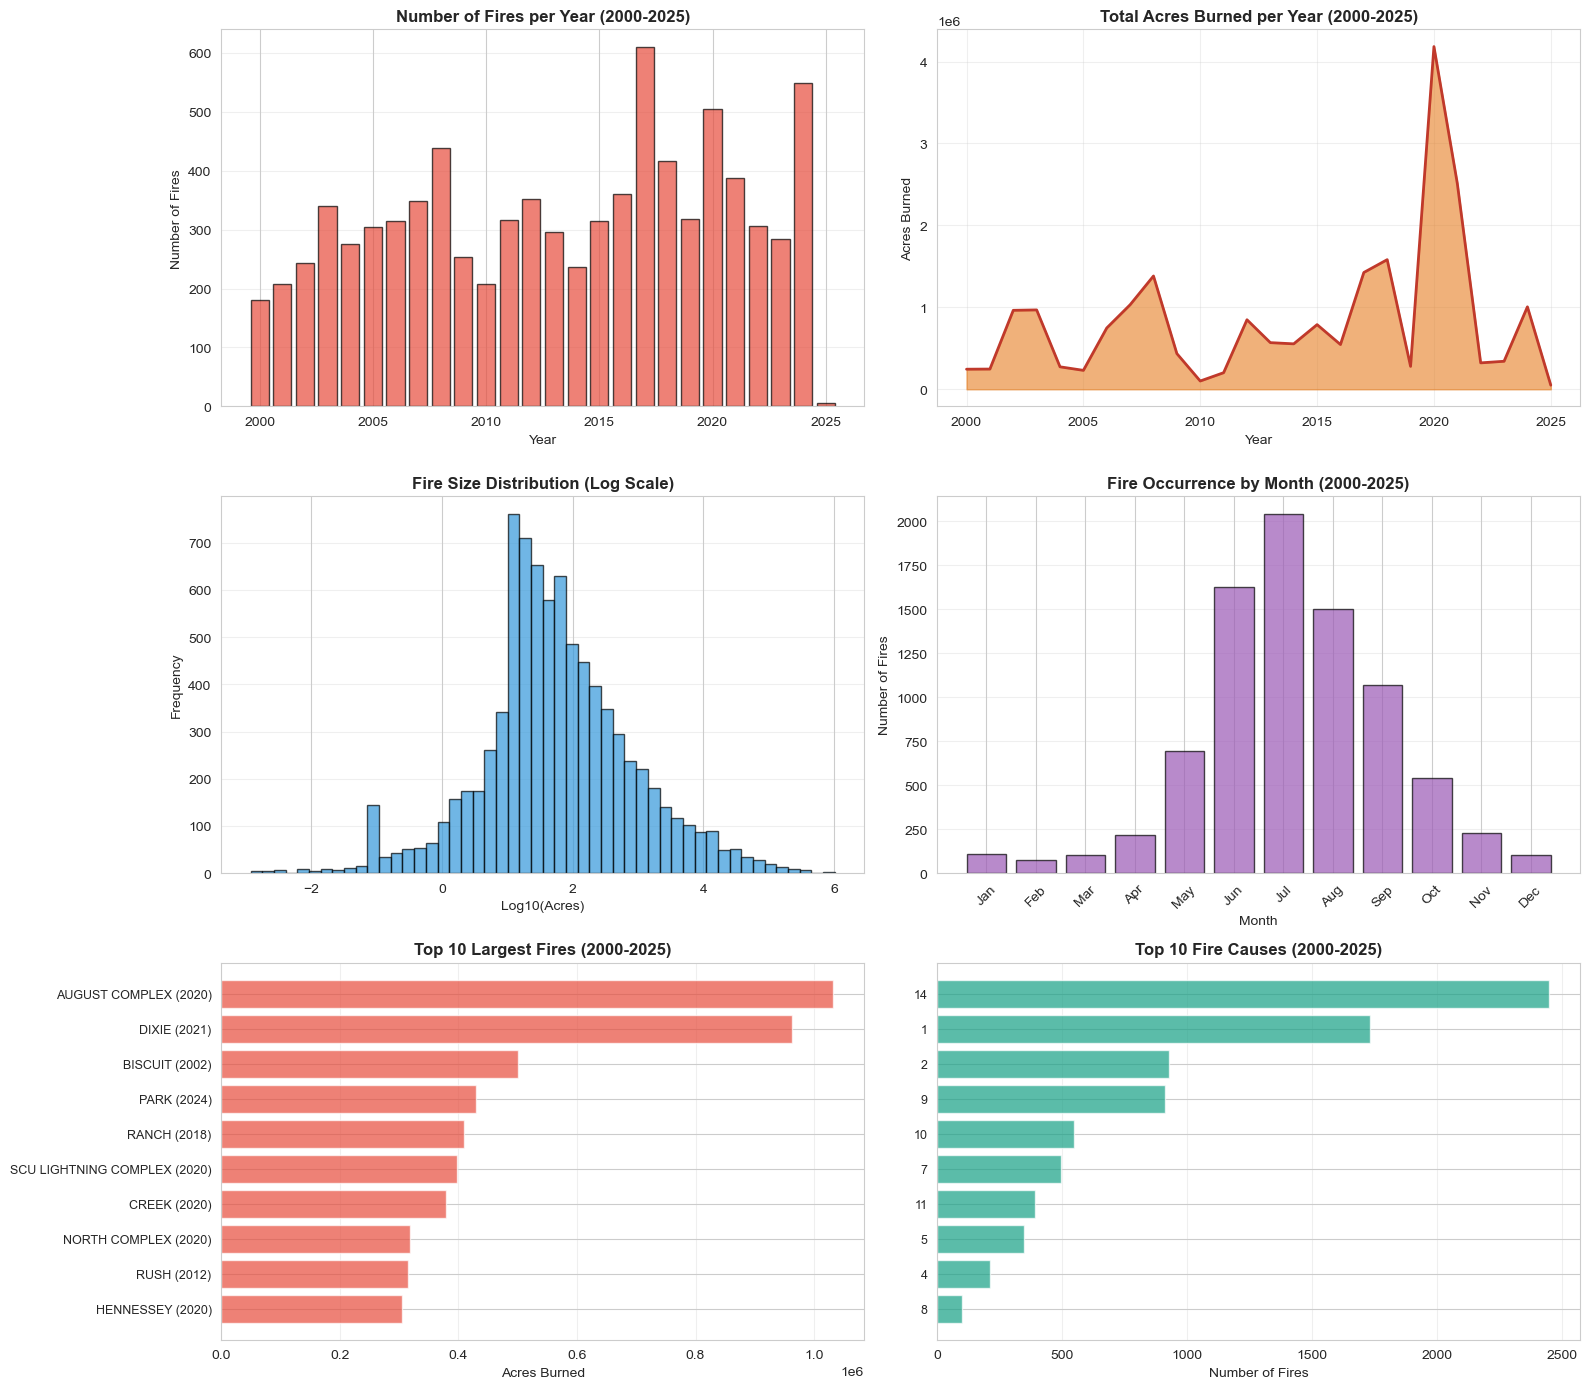


✅ Fire visualizations complete!


In [5]:
# Parse dates
fires_gdf['ALARM_DATE'] = pd.to_datetime(fires_gdf['ALARM_DATE'], errors='coerce')
fires_gdf['CONT_DATE'] = pd.to_datetime(fires_gdf['CONT_DATE'], errors='coerce')

# Focus on 2000-2025 for modeling
fires_modern = fires_gdf[fires_gdf['YEAR_'] >= 2000].copy()

print("=" * 80)
print("FIRE DATA VISUALIZATIONS (2000-2025)")
print("=" * 80)

import numpy as np

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. Fires per Year
fires_per_year = fires_modern.groupby('YEAR_').size()
axes[0, 0].bar(fires_per_year.index, fires_per_year.values, color='#E74C3C', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Number of Fires per Year (2000-2025)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Fires')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Total Acres Burned per Year
acres_per_year = fires_modern.groupby('YEAR_')['GIS_ACRES'].sum()
axes[0, 1].fill_between(acres_per_year.index, acres_per_year.values, color='#E67E22', alpha=0.6)
axes[0, 1].plot(acres_per_year.index, acres_per_year.values, color='#C0392B', linewidth=2)
axes[0, 1].set_title('Total Acres Burned per Year (2000-2025)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Acres Burned')
axes[0, 1].grid(True, alpha=0.3)

# 3. Fire Size Distribution (Log Scale)
fire_sizes = fires_modern['GIS_ACRES'].dropna()
fire_sizes = fire_sizes[fire_sizes > 0]  # Remove zero/negative values
axes[1, 0].hist(np.log10(fire_sizes), bins=50, color='#3498DB', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Fire Size Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Log10(Acres)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Monthly Fire Occurrence
fires_modern['Month'] = fires_modern['ALARM_DATE'].dt.month
monthly_fires = fires_modern.groupby('Month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1, 1].bar(range(1, 13), [monthly_fires.get(i, 0) for i in range(1, 13)], 
               color='#9B59B6', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Fire Occurrence by Month (2000-2025)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Fires')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(month_names, rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 5. Top 10 Largest Fires
top_10_fires = fires_modern.nlargest(10, 'GIS_ACRES')[['FIRE_NAME', 'GIS_ACRES', 'YEAR_']].copy()
top_10_fires['Label'] = top_10_fires['FIRE_NAME'] + ' (' + top_10_fires['YEAR_'].astype(int).astype(str) + ')'
axes[2, 0].barh(range(10), top_10_fires['GIS_ACRES'].values, color='#E74C3C', alpha=0.7)
axes[2, 0].set_yticks(range(10))
axes[2, 0].set_yticklabels(top_10_fires['Label'].values, fontsize=9)
axes[2, 0].set_title('Top 10 Largest Fires (2000-2025)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Acres Burned')
axes[2, 0].invert_yaxis()
axes[2, 0].grid(True, alpha=0.3, axis='x')

# 6. Fire Cause Distribution (if available)
if 'CAUSE' in fires_modern.columns:
    cause_counts = fires_modern['CAUSE'].value_counts().head(10)
    axes[2, 1].barh(range(len(cause_counts)), cause_counts.values, color='#16A085', alpha=0.7)
    axes[2, 1].set_yticks(range(len(cause_counts)))
    axes[2, 1].set_yticklabels(cause_counts.index, fontsize=9)
    axes[2, 1].set_title('Top 10 Fire Causes (2000-2025)', fontsize=12, fontweight='bold')
    axes[2, 1].set_xlabel('Number of Fires')
    axes[2, 1].invert_yaxis()
    axes[2, 1].grid(True, alpha=0.3, axis='x')
else:
    axes[2, 1].text(0.5, 0.5, 'Cause data not available', 
                    ha='center', va='center', fontsize=12)
    axes[2, 1].set_title('Fire Causes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Fire visualizations complete!")
print("=" * 80)


In [6]:
# Step 0: Check Fire Data and Add Year/Month Columns
print('='*60)
print('CHECKING FIRE DATA AND ADDING YEAR/MONTH COLUMNS')
print('='*60)

# Check if Year and Month columns exist
print(f'Available columns: {list(fires_gdf.columns)}')

if 'Year' not in fires_gdf.columns or 'Month' not in fires_gdf.columns:
    print('Adding Year and Month columns...')
    # Parse dates and add Year/Month columns
    fires_gdf['ALARM_DATE'] = pd.to_datetime(fires_gdf['ALARM_DATE'], errors='coerce')
    fires_gdf['Year'] = fires_gdf['ALARM_DATE'].dt.year
    fires_gdf['Month'] = fires_gdf['ALARM_DATE'].dt.month
    
    # Filter to 2000+ if not already done
    if 'YEAR_' in fires_gdf.columns:
        fires_gdf = fires_gdf[fires_gdf['YEAR_'] >= 2000].copy()
    
    print(f'✅ Added Year and Month columns')
    print(f'   Date range: {fires_gdf["ALARM_DATE"].min()} to {fires_gdf["ALARM_DATE"].max()}')
    print(f'   Records after filtering: {len(fires_gdf):,}')
else:
    print('✅ Year and Month columns already exist')

print(f'\nSample data with Year/Month:')
print(fires_gdf[['FIRE_NAME', 'ALARM_DATE', 'UNIT_ID', 'Year', 'Month', 'GIS_ACRES']].head())


CHECKING FIRE DATA AND ADDING YEAR/MONTH COLUMNS
Available columns: ['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'IRWINID', 'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'CAUSE', 'COMPLEX_NAME', 'COMPLEX_ID', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'FIRE_NUM', 'Shape_Length', 'Shape_Area', 'geometry']
Adding Year and Month columns...
✅ Added Year and Month columns
   Date range: 2000-01-01 00:00:00+00:00 to 2025-01-22 00:00:00+00:00
   Records after filtering: 8,366

Sample data with Year/Month:
   FIRE_NAME                ALARM_DATE UNIT_ID    Year  Month     GIS_ACRES
0  PALISADES 2025-01-07 00:00:00+00:00     LDF  2025.0    1.0  23448.882812
1      EATON 2025-01-08 00:00:00+00:00     LAC  2025.0    1.0  14056.260742
2     HUGHES 2025-01-22 00:00:00+00:00     ANF  2025.0    1.0  10396.798828
3    KENNETH 2025-01-09 00:00:00+00:00     VNC  2025.0    1.0    998.737793
4      HURST 2025-01-07 00:00:00+00:00     LDF  2025.0    1.0    831.385498


In [7]:
## 4. Convert Fire Data to CSV with Unit-Month Grid

In [8]:
# Step 1: Map CAL FIRE Unit Codes to Counties
print('='*60)
print('MAPPING CAL FIRE CODES TO COUNTIES')
print('='*60)

# Comprehensive CAL FIRE unit code to county mapping
cal_fire_to_county = {
    # Major CAL FIRE Units
    'BDU': 'BUTTE', 'LNU': 'LAKE', 'SCU': 'SANTA CLARA', 'NEU': 'NEVADA',
    'TCU': 'TUOLUMNE', 'RRU': 'RIVERSIDE', 'CZU': 'SANTA CRUZ', 'SHU': 'SHASTA',
    'LMU': 'LOS ANGELES', 'MVU': 'MADERA', 'BEU': 'BUTTE', 'KRN': 'KERN',
    'CCU': 'CONTRA COSTA', 'HUM': 'HUMBOLDT', 'SQF': 'FRESNO', 'PLU': 'PLUMAS',
    'MEU': 'MENDOCINO', 'SKU': 'SISKIYOU', 'SDU': 'SAN DIEGO', 'MDF': 'SAN DIEGO',
    
    # Federal Agencies
    'ANF': 'LOS ANGELES', 'CNF': 'LOS ANGELES', 'ENF': 'EL DORADO', 'INF': 'INYO',
    'KNF': 'KERN', 'LNF': 'LOS ANGELES', 'MNF': 'MENDOCINO', 'PNF': 'PLUMAS',
    'SNF': 'SHASTA', 'TNF': 'TUOLUMNE',
    
    # Additional mappings
    'ADR': 'ALPINE', 'AEU': 'ALAMEDA', 'AFV': 'AMADOR', 'APF': 'ALPINE',
    'BBD': 'BUTTE', 'BEA': 'BUTTE', 'BNP': 'BUTTE', 'BRR': 'BUTTE',
    'CCD': 'CONTRA COSTA', 'CDD': 'CONTRA COSTA', 'CLR': 'COLUSA', 'CND': 'CONTRA COSTA',
    'CNP': 'CONTRA COSTA', 'CRA': 'CONTRA COSTA', 'CRB': 'CONTRA COSTA', 'CRD': 'CONTRA COSTA',
    'DBR': 'DEL NORTE', 'DLR': 'DEL NORTE', 'DVP': 'DEL NORTE', 'ESR': 'EL DORADO',
    'FKU': 'FRESNO', 'FNF': 'FRESNO', 'FWR': 'FRESNO', 'FYA': 'FRESNO',
    'GNP': 'GLENN', 'HIA': 'HUMBOLDT', 'HPR': 'HUMBOLDT', 'HTF': 'HUMBOLDT',
    'HUU': 'HUMBOLDT', 'JTP': 'IMPERIAL', 'KNP': 'KERN', 'KRR': 'KERN',
    'LAD': 'LOS ANGELES', 'LFD': 'LOS ANGELES', 'LKR': 'LAKE', 'LNP': 'LAKE',
    'LUR': 'LAKE', 'MCP': 'MADERA', 'MCR': 'MADERA', 'MDR': 'MADERA',
    'MMU': 'MADERA', 'MNP': 'MARIN', 'MRN': 'MARIN', 'NOD': 'NEVADA',
    'PIP': 'PLACER', 'PLR': 'PLACER', 'RNP': 'RIVERSIDE', 'RRS': 'RIVERSIDE',
    'RWP': 'RIVERSIDE', 'SBC': 'SAN BERNARDINO', 'SCA': 'SANTA CLARA',
    'SHF': 'SHASTA', 'SIF': 'SISKIYOU', 'SJR': 'SAN JOAQUIN', 'SKR': 'SISKIYOU',
    'SLU': 'SAN LUIS OBISPO', 'SMP': 'SAN MATEO', 'SOR': 'SONOMA',
    'SPR': 'SACRAMENTO', 'SRF': 'SACRAMENTO', 'SRR': 'SACRAMENTO',
    'STF': 'STANISLAUS', 'STR': 'STANISLAUS', 'SWR': 'SOLANO',
    'TGU': 'TEHAMA', 'TIA': 'TULARE', 'TKR': 'TEHAMA', 'TMU': 'TUOLUMNE',
    'TNR': 'TUOLUMNE', 'TNT': 'TUOLUMNE', 'TOI': 'TRINITY', 'TUU': 'TUOLUMNE',
    'VLJ': 'VENTURA', 'VNC': 'VENTURA', 'WED': 'YOLO', 'YNP': 'MARIPOSA'
}

print(f'Created mapping for {len(cal_fire_to_county)} CAL FIRE unit codes')

# Apply mapping to fire data
print(f'\nApplying mapping to fire data...')
fires_gdf['County'] = fires_gdf['UNIT_ID'].map(cal_fire_to_county)

# Check mapping results
mapped_count = fires_gdf['County'].notna().sum()
unmapped_count = fires_gdf['County'].isna().sum()
total_count = len(fires_gdf)

print(f'Mapping results:')
print(f'   Mapped: {mapped_count:,} records ({mapped_count/total_count*100:.1f}%)')
print(f'   Unmapped: {unmapped_count:,} records ({unmapped_count/total_count*100:.1f}%)')

if unmapped_count > 0:
    unmapped_units = fires_gdf[fires_gdf['County'].isna()]['UNIT_ID'].unique()
    unmapped_clean = [unit for unit in unmapped_units if unit is not None]
    print(f'   Still unmapped: {sorted(unmapped_clean)}')

print(f'\n✅ County mapping complete!')


MAPPING CAL FIRE CODES TO COUNTIES
Created mapping for 106 CAL FIRE unit codes

Applying mapping to fire data...
Mapping results:
   Mapped: 7,419 records (88.7%)
   Unmapped: 947 records (11.3%)
   Still unmapped: ['BDF', 'BTU', 'LAC', 'LDF', 'LPF', 'ORC']

✅ County mapping complete!


In [9]:
# Step 2: Aggregate Fire Data by Unit-Month
print('='*60)
print('AGGREGATING FIRE DATA BY UNIT-MONTH')
print('='*60)

# Aggregate fires by UNIT_ID (fire station), Year, and Month
fire_agg = fires_gdf.groupby(['UNIT_ID', 'Year', 'Month']).agg({
    'FIRE_NAME': 'count',           # Count of fires
    'GIS_ACRES': ['sum', 'mean', 'max']  # Total, average, max acres
}).reset_index()

# Flatten column names
fire_agg.columns = ['Unit_ID', 'Year', 'Month', 'Fire_Count', 'Total_Acres', 'Avg_Acres', 'Max_Acres']

# Add fire occurrence flag (1 if fires occurred, 0 if not)
fire_agg['Fire_Occurred'] = 1

# Add county column
fire_agg['County'] = fire_agg['Unit_ID'].map(cal_fire_to_county)

print(f'✅ Aggregated fire data by unit-month')
print(f'   Shape: {fire_agg.shape}')
print(f'   Unique units: {fire_agg["Unit_ID"].nunique()}')
print(f'   Unique county-months with fires: {len(fire_agg):,}')

# Show sample data
print(f'\nSample aggregated fire data:')
print(fire_agg.head(10))

print(f'\n✅ Fire aggregation complete!')


AGGREGATING FIRE DATA BY UNIT-MONTH
✅ Aggregated fire data by unit-month
   Shape: (3895, 9)
   Unique units: 109
   Unique county-months with fires: 3,895

Sample aggregated fire data:
  Unit_ID    Year  Month  Fire_Count  Total_Acres   Avg_Acres    Max_Acres  \
0     ADR  2024.0    5.0           1    10.833637   10.833637    10.833637   
1     ADR  2024.0    6.0           2     7.316390    3.658195     5.348492   
2     AEU  2001.0    5.0           1    33.491177   33.491177    33.491177   
3     AEU  2001.0    6.0           4  2457.916260  614.479065  1670.782227   
4     AEU  2001.0    7.0           8  1565.861328  195.732666   546.545471   
5     AEU  2001.0    8.0           2   113.796837   56.898418    98.698631   
6     AEU  2002.0    6.0           2  1023.790039  511.895020   702.274475   
7     AEU  2002.0    7.0           2   148.194550   74.097275    80.640083   
8     AEU  2002.0    8.0           4   841.230164  210.307541   775.833130   
9     AEU  2002.0    9.0          

In [10]:
# Step 3: Create Complete Unit-Month Grid
print('='*60)
print('CREATING COMPLETE UNIT-MONTH GRID')
print('='*60)

# Get all unique fire units from our data (filter out None values)
all_units = sorted([unit for unit in fires_gdf['UNIT_ID'].unique() if unit is not None])
print(f'✅ Found {len(all_units)} unique fire units')

# Create complete grid for all units, years, and months
years = range(2000, 2026)
months = range(1, 13)

print(f'Creating complete grid...')
print(f'   Units: {len(all_units)}')
print(f'   Years: {len(years)} (2000-2025)')
print(f'   Months: {len(months)} (1-12)')
print(f'   Total combinations: {len(all_units) * len(years) * len(months):,}')

# Create the grid
complete_grid = []
for unit in all_units:
    for year in years:
        for month in months:
            complete_grid.append({
                'Unit_ID': unit,
                'Year': year,
                'Month': month
            })

complete_grid_df = pd.DataFrame(complete_grid)
print(f'\n✅ Created complete grid: {complete_grid_df.shape}')

print(f'\n✅ Complete grid creation complete!')


CREATING COMPLETE UNIT-MONTH GRID
✅ Found 109 unique fire units
Creating complete grid...
   Units: 109
   Years: 26 (2000-2025)
   Months: 12 (1-12)
   Total combinations: 34,008

✅ Created complete grid: (34008, 3)

✅ Complete grid creation complete!


In [11]:
# Step 4: Merge Fire Data with Complete Grid and Save CSV
print('='*60)
print('MERGING FIRE DATA WITH COMPLETE GRID AND SAVING CSV')
print('='*60)

# Merge fire data with complete grid
print('Merging fire data with complete grid...')
merged_fire_data = complete_grid_df.merge(
    fire_agg,
    on=['Unit_ID', 'Year', 'Month'],
    how='left'
)

# Fill missing values with 0 (no fires occurred)
fire_columns = ['Fire_Occurred', 'Fire_Count', 'Total_Acres', 'Avg_Acres', 'Max_Acres', 'County']
for col in fire_columns:
    if col in merged_fire_data.columns:
        if col == 'County':
            # For county, we need to map from Unit_ID if missing
            merged_fire_data['County'] = merged_fire_data['Unit_ID'].map(cal_fire_to_county)
        else:
            merged_fire_data[col] = merged_fire_data[col].fillna(0)

print(f'✅ Merged fire data with complete grid')
print(f'   Final shape: {merged_fire_data.shape}')

# Check fire occurrence statistics
total_rows = len(merged_fire_data)
fire_rows = (merged_fire_data['Fire_Occurred'] == 1).sum()
no_fire_rows = (merged_fire_data['Fire_Occurred'] == 0).sum()

print(f'\nFire occurrence statistics:')
print(f'   Rows with fires: {fire_rows:,} ({fire_rows/total_rows*100:.2f}%)')
print(f'   Rows without fires: {no_fire_rows:,} ({no_fire_rows/total_rows*100:.2f}%)')

# Save to CSV
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

fire_csv_file = output_dir / 'fire_data_complete_unit_month.csv'
merged_fire_data.to_csv(fire_csv_file, index=False)

print(f'\n✅ Fire data CSV saved to: {fire_csv_file}')
print(f'   File size: {fire_csv_file.stat().st_size / (1024*1024):.2f} MB')

# Show final summary
print(f'\n📊 FINAL FIRE DATA SUMMARY:')
print(f'   File: fire_data_complete_unit_month.csv')
print(f'   Rows: {len(merged_fire_data):,}')
print(f'   Columns: {merged_fire_data.shape[1]}')
print(f'   Fire units: {merged_fire_data["Unit_ID"].nunique()}')
print(f'   Years: {merged_fire_data["Year"].nunique()} (2000-2025)')
print(f'   Months: {merged_fire_data["Month"].nunique()} (1-12)')
print(f'   Fire occurrence rate: {(merged_fire_data["Fire_Occurred"] == 1).mean()*100:.2f}%')

print(f'\n🎯 Fire data CSV file is ready for merging with other datasets!')


MERGING FIRE DATA WITH COMPLETE GRID AND SAVING CSV
Merging fire data with complete grid...
✅ Merged fire data with complete grid
   Final shape: (34008, 9)

Fire occurrence statistics:
   Rows with fires: 3,895 (11.45%)
   Rows without fires: 30,113 (88.55%)

✅ Fire data CSV saved to: ../data/processed/fire_data_complete_unit_month.csv
   File size: 1.35 MB

📊 FINAL FIRE DATA SUMMARY:
   File: fire_data_complete_unit_month.csv
   Rows: 34,008
   Columns: 9
   Fire units: 109
   Years: 26 (2000-2025)
   Months: 12 (1-12)
   Fire occurrence rate: 11.45%

🎯 Fire data CSV file is ready for merging with other datasets!
